# Droid Policy Image Debugger

Utilities for inspecting images before and after they pass through the policy input transforms.
Instantiate the policy, feed it an observation, and use the helpers below to visualize orientation
at each transform stage.

In [4]:
import copy
import dataclasses
from typing import Protocol
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tyro

from openpi import transforms as _transforms
from openpi.models import model as _model
import openpi.models.pi0_fast as pi0_fast
from openpi.policies import policy_config as _policy_config
from openpi.training.config import AssetsConfig, DataConfig, DataConfigFactory, ModelTransformFactory, TrainConfig
from openpi.shared import download


In [5]:
def _parse_image(image) -> np.ndarray:
    image = np.asarray(image)
    if np.issubdtype(image.dtype, np.floating):
        image = (255 * image).astype(np.uint8)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    return image


@dataclasses.dataclass(frozen=True)
class DroidInputs(_transforms.DataTransformFn):
    action_dim: int
    model_type: _model.ModelType = _model.ModelType.PI0_FAST

    def __call__(self, data: dict) -> dict:
        state = np.concatenate([
            np.asarray(data["observation/joint_position"]),
            np.asarray(data["observation/gripper_position"]),
        ])
        state = _transforms.pad_to_dim(state, self.action_dim)

        base_image = _parse_image(data["observation/exterior_image_1_left"])
        wrist_image = _parse_image(data["observation/wrist_image_left"])

        match self.model_type:
            case _model.ModelType.PI0 | _model.ModelType.PI05:
                names = ("base_0_rgb", "left_wrist_0_rgb", "right_wrist_0_rgb")
                images = (base_image, wrist_image, np.zeros_like(base_image))
                image_masks = (np.True_, np.True_, np.False_)
            case _model.ModelType.PI0_FAST:
                names = ("base_0_rgb", "base_1_rgb", "wrist_0_rgb")
                images = (base_image, np.zeros_like(base_image), wrist_image)
                image_masks = (np.True_, np.True_, np.True_)
            case _:
                raise ValueError(f"Unsupported model type: {self.model_type}")

        inputs = {
            "state": state,
            "image": dict(zip(names, images, strict=True)),
            "image_mask": dict(zip(names, image_masks, strict=True)),
        }

        if "actions" in data:
            inputs["actions"] = data["actions"]
        if "prompt" in data:
            inputs["prompt"] = data["prompt"]
        return inputs


@dataclasses.dataclass(frozen=True)
class DroidOutputs(_transforms.DataTransformFn):
    def __call__(self, data: dict) -> dict:
        return {"actions": np.asarray(data["actions"][:, :8])}


class GroupFactory(Protocol):
    def __call__(self, model_config: _model.BaseModelConfig) -> _transforms.Group:
        ...


@dataclasses.dataclass(frozen=True)
class SimpleDataConfig(DataConfigFactory):
    data_transforms: tyro.conf.Suppress[GroupFactory] = dataclasses.field(
        default_factory=lambda: (lambda model_config: _transforms.Group(inputs=[], outputs=[]))
    )
    model_transforms: tyro.conf.Suppress[GroupFactory] = dataclasses.field(
        default_factory=ModelTransformFactory
    )

    def create(self, assets_dirs, model_config):
        return dataclasses.replace(
            self.create_base_config(assets_dirs, model_config),
            data_transforms=self.data_transforms(model_config),
            model_transforms=self.model_transforms(model_config),
            use_quantile_norm=model_config.model_type == _model.ModelType.PI0_FAST,
        )


def build_droid_fast_policy(
    *,
    checkpoint="gs://openpi-assets/checkpoints/pi0_fast_droid",
    action_dim=8,
    action_horizon=10,
):
    checkpoint_dir = download.maybe_download(checkpoint)
    model_cfg = pi0_fast.Pi0FASTConfig(action_dim=action_dim, action_horizon=action_horizon)
    delta_mask = np.array([1] * (action_dim - 1) + [0], dtype=bool)

    data_factory = SimpleDataConfig(
        assets=AssetsConfig(asset_id="droid"),
        data_transforms=lambda model: _transforms.Group(
            inputs=[
                DroidInputs(action_dim=model.action_dim, model_type=_model.ModelType.PI0_FAST),
            ],
            outputs=[
                _transforms.AbsoluteActions(delta_mask),
                DroidOutputs(),
            ],
        ),
        base_config=DataConfig(prompt_from_task=True),
    )

    train_config = TrainConfig(
        name="pi0_droid_fast",
        model=model_cfg,
        data=data_factory,
    )

    return _policy_config.create_trained_policy(
        train_config=train_config,
        checkpoint_dir=checkpoint_dir,
    )


def load_observation_npz(path: str | pathlib.Path) -> dict[str, np.ndarray | str]:
    """Load an observation snapshot saved by the policy node."""
    snapshot_path = pathlib.Path(path)
    with np.load(snapshot_path, allow_pickle=True) as data:
        observation: dict[str, np.ndarray | str] = {}
        for key in data.files:
            restored_key = key.replace("__", "/")
            value = data[key]
            if value.shape == (1,) and value.dtype.kind in {"U", "S", "O"}:
                observation[restored_key] = value.item()
            else:
                observation[restored_key] = np.asarray(value)
    return observation

def extract_observation_images(observation: dict) -> dict[str, np.ndarray]:
    return {
        "observation/exterior_image_1_left": np.asarray(observation["observation/exterior_image_1_left"]),
        "observation/wrist_image_left": np.asarray(observation["observation/wrist_image_left"])
    }


def collect_policy_image_stages(policy, observation: dict) -> list[tuple[str, dict[str, np.ndarray]]]:
    data = copy.deepcopy(observation)
    stages: list[tuple[str, dict[str, np.ndarray]]] = []
    for transform in policy._input_transform.transforms:
        data = transform(data)
        if "image" in data:
            stages.append(
                (
                    transform.__class__.__name__,
                    {name: np.asarray(img) for name, img in data["image"].items()},
                )
            )
    return stages


def _prepare_for_display(image: np.ndarray) -> np.ndarray:
    array = np.asarray(image)
    if array.ndim == 3 and array.shape[-1] == 1:
        array = array[..., 0]
    if array.dtype != np.uint8:
        array_min = float(array.min())
        array_max = float(array.max())
        if array_max - array_min > 1e-6:
            array = (array - array_min) / (array_max - array_min)
        else:
            array = np.zeros_like(array, dtype=np.float32)
    return array


def plot_image_grid(image_dict: dict[str, np.ndarray], *, title: str | None = None):
    if not image_dict:
        raise ValueError("No images provided")
    num_images = len(image_dict)
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
    if num_images == 1:
        axes = [axes]
    for ax, (name, image) in zip(axes, image_dict.items()):
        array = _prepare_for_display(image)
        if array.dtype == np.uint8:
            ax.imshow(array)
        else:
            ax.imshow(array, cmap="gray")
        ax.set_title(name)
        ax.axis("off")
    if title:
        fig.suptitle(title)
    fig.tight_layout()
    return fig, axes


def plot_observation_images(observation: dict, *, title: str | None = None):
    return plot_image_grid(extract_observation_images(observation), title=title)


def visualize_policy_images(policy, observation: dict):
    plot_observation_images(observation, title="Raw observation")
    for stage_name, images in collect_policy_image_stages(policy, observation):
        plot_image_grid(images, title=f"After {stage_name}")


(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'observation/exterior_image_1_left'}>,
        <Axes: title={'center': 'observation/wrist_image_left'}>],
       dtype=object))

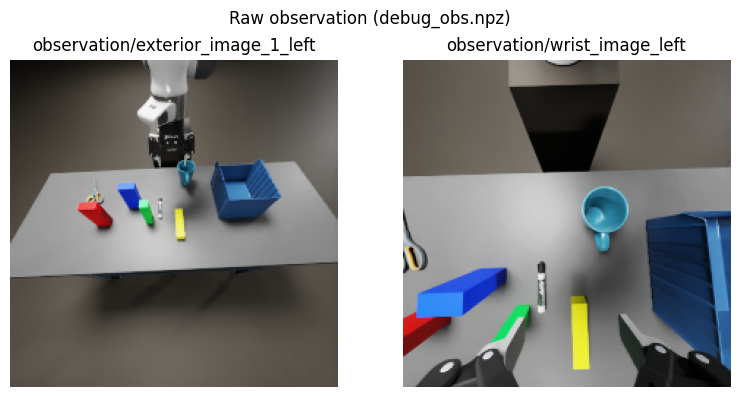

In [6]:
DEBUG_OBS_PATH = pathlib.Path("debug_obs.npz")

if not DEBUG_OBS_PATH.exists():
    raise FileNotFoundError(f"Observation snapshot not found: {DEBUG_OBS_PATH}")

observation = load_observation_npz(DEBUG_OBS_PATH)
plot_observation_images(observation, title=f"Raw observation ({DEBUG_OBS_PATH.name})")


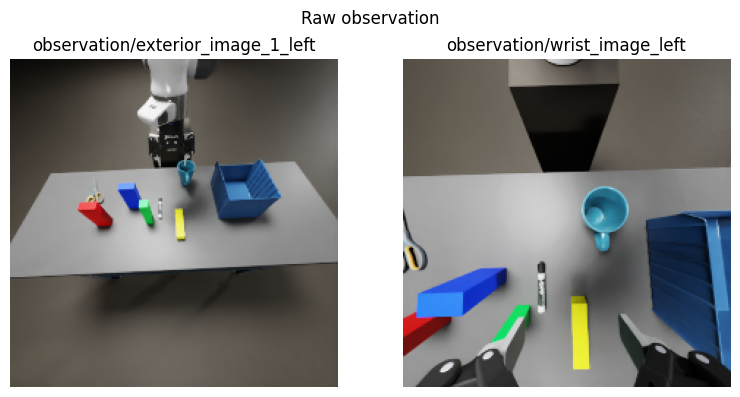

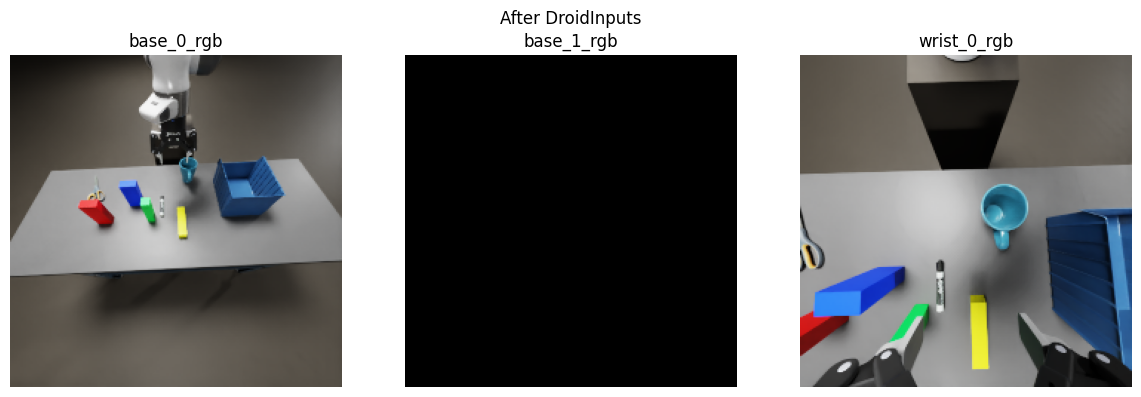

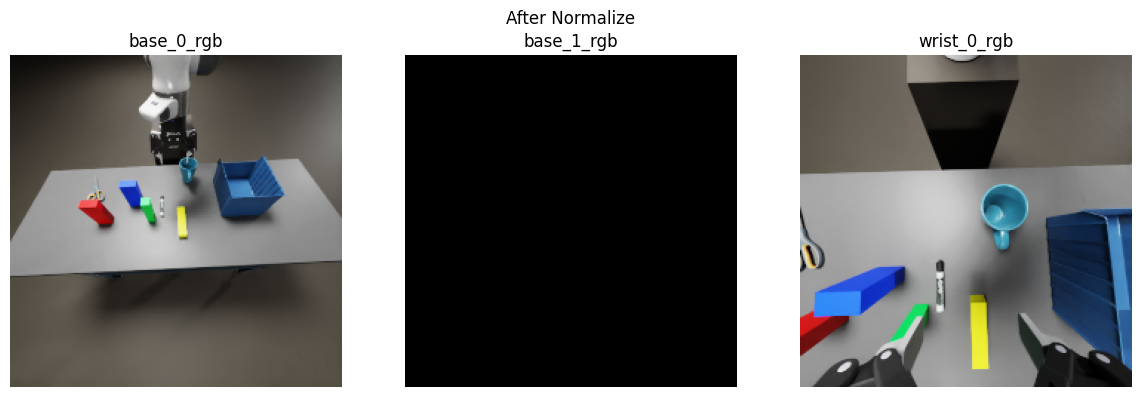

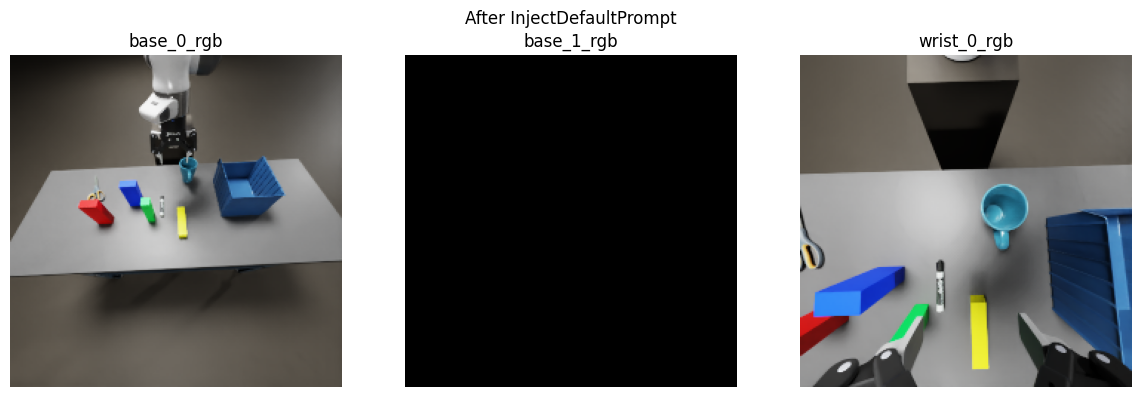

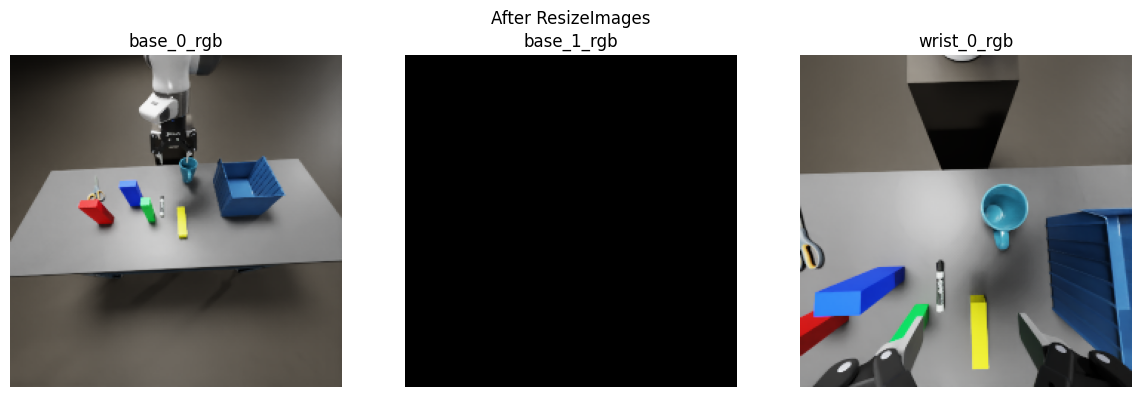

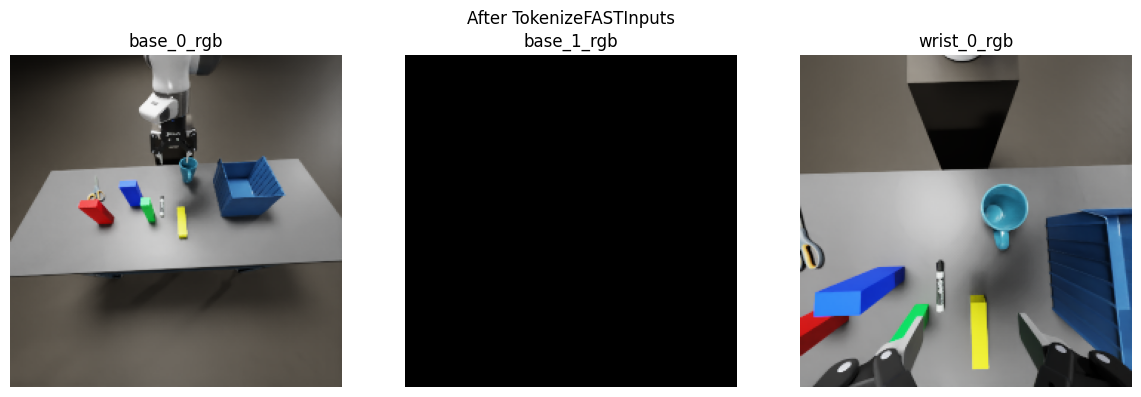

In [7]:
try:
    policy
except NameError:
    policy = build_droid_fast_policy()

visualize_policy_images(policy, observation)
